### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [407]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [408]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


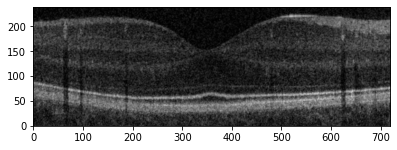

In [409]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [410]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


In [411]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [412]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [413]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

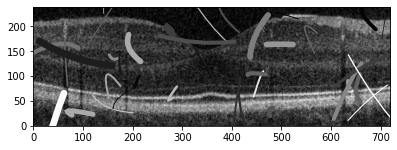

In [414]:
# Initialise clew of 40 and draw

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

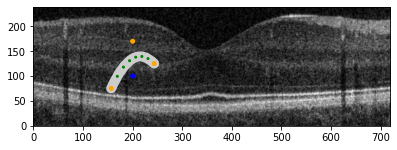

In [415]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

&copy; Cara MacNish, UWA, 2024

# Quadratic approximation of worms

In [416]:
# Initialise clew
clew = initialise_clew(40, image.shape, (40, 30, 1))

In [417]:
points = clew[1].intermediate_points()


Quadratic function approximation: f(x) = 0.45x^2 + -91.16x + 4641.96


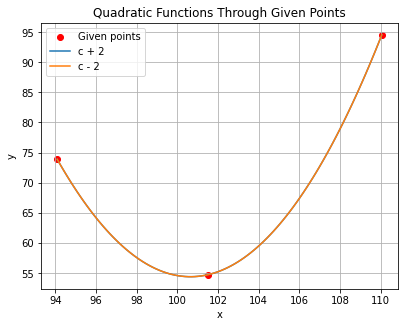

In [418]:
import numpy as np
import matplotlib.pyplot as plt

def quadratic_approximation(control_points):
    # Unpack the control points
    x_values = np.array([point[0] for point in control_points])
    y_values = np.array([point[1] for point in control_points])
    
    # Set up the matrix equations
    A = np.vstack([x_values**2, x_values, np.ones_like(x_values)]).T
    coefficients = np.linalg.lstsq(A, y_values, rcond=None)[0]
    
    return coefficients
    
def plot_quadratic_function(a, b, c, points, ax, label=None):
    # Generate x values for plotting
    x_values = np.linspace(min([point[0] for point in points]), max([point[0] for point in points]), 100)
    
    # Calculate corresponding y values using the quadratic function
    y_values = a * x_values**2 + b * x_values + c
    
    # Plot the quadratic function
    ax.plot(x_values, y_values, label=label)



# Get coefficients for the quadratic function approximation
a, b, c = quadratic_approximation(points)

# Print the coefficients
print("Quadratic function approximation: f(x) = {:.2f}x^2 + {:.2f}x + {:.2f}".format(a, b, c))

# Create a figure and axis for the subplots
fig, ax = plt.subplots()

# Plot the original points
ax.scatter([point[0] for point in points], [point[1] for point in points], color='red', label='Given points')

# Plot the quadratic functions with adjusted c values
plot_quadratic_function(a, b, c + clew[1].width//2, points, ax, label='c + 2')
plot_quadratic_function(a, b, c - clew[1].width//2, points, ax, label='c - 2')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Quadratic Functions Through Given Points')
ax.legend()
ax.grid(True)

plt.show()


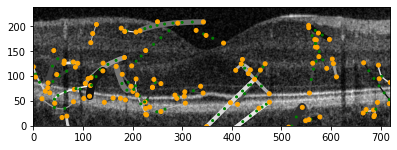

In [419]:
drawing = Drawing(image)
drawing.add_worms(clew)

for worm in clew:
    drawing.add_dots(worm.intermediate_points(), radius=2, color='green')
    drawing.add_dots(worm.control_points(),color='orange')
drawing.show()

In [420]:
import numpy as np
from sklearn.cluster import KMeans

def calculate_kmeans_inertia(points, num_clusters):
    # Convert points to NumPy array
    points_array = np.array(points)
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(points_array)
    
    # Calculate inertia
    inertia = kmeans.inertia_
    
    return inertia

# Assuming `clew` is an object or variable containing a single clew,
# and each clew has a method `intermediate_points()` to retrieve its points

# Initialize a list to store inertia values for each worm within the clew
worm_inertia_values = []

# Initialize a list to store intermediate points for all worms within the clew
all_worm_points = []

# Iterate over all worms in the clew
for worm in clew:
    # Get points for the current worm
    worm_points = worm.intermediate_points()
    
    # Extend the list of all worm points with the points of the current worm
    all_worm_points.extend(worm_points)

# Calculate the number of worms (clusters) within the clew
num_worms = len(clew)

# Calculate k-means inertia for the entire clew (all worms)
inertia = calculate_kmeans_inertia(all_worm_points, num_worms)

# Print the inertia value for the entire clew
print(f"Clew K-means inertia: {inertia}")


Clew K-means inertia: 47839.57438853911


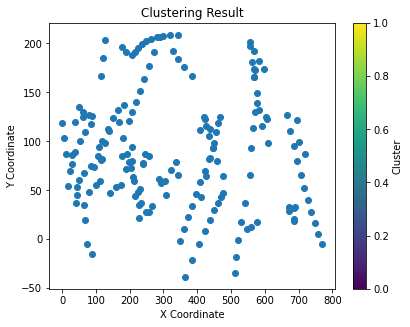

In [421]:
import matplotlib.pyplot as plt

# Assuming `labels` contains the cluster assignments for each point
# Plot the intermediate points of the clew
plt.scatter([point[0] for point in all_worm_points], [point[1] for point in all_worm_points])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Clustering Result')
plt.colorbar(label='Cluster')
plt.show()


In [422]:
all_worm_points = [worm.intermediate_points() for worm in clew]

In [423]:
all_worm_points

[(array([304.20232498,  59.15009779]),
  array([291.94836042,  57.51689103]),
  array([285.25218852,  61.42809226])),
 (array([101.50339539,  54.72095195]),
  array([94.08746994, 73.88664461]),
  array([110.0652362,  94.5447369])),
 (array([407.82482083, 111.41156012]),
  array([421.9747223 , 122.57211702]),
  array([437.381135  , 112.28140848])),
 (array([23.90820329, 69.29720219]),
  array([12.42809259, 87.38743926]),
  array([  4.41370409, 103.7550392 ]),
  array([ -0.13496223, 118.40000201])),
 (array([475.35138198,  64.18054329]),
  array([459.61628493,  79.55112562]),
  array([446.10598154,  93.2539466 ]),
  array([434.82047181, 105.28900622]),
  array([425.75975574, 115.65630449]),
  array([418.92383334, 124.3558414 ])),
 (array([80.66902809, 48.06505639]),
  array([63.33889369, 34.60347498]),
  array([42.16040751, 36.58529075]),
  array([17.13356957, 54.01050369])),
 (array([411.49691033,  42.80600156]),
  array([425.81462287,  64.22843778]),
  array([438.11722586,  82.52810644

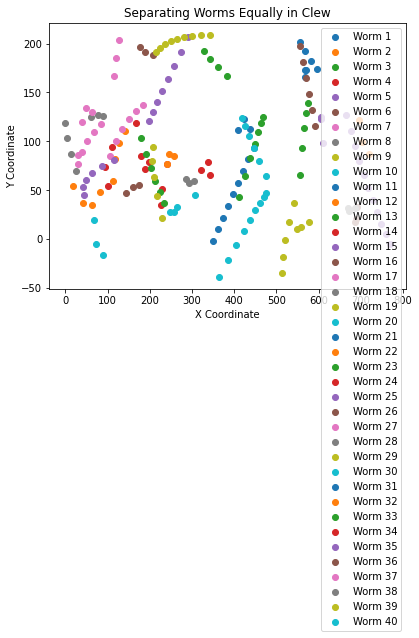

In [424]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming `all_worm_points` is a list of lists where each inner list contains the intermediate points of a single worm

# Step 1: Compute centroids
centroids = [np.mean(worm_points, axis=0) for worm_points in all_worm_points]
centroids_array = np.array(centroids)

# Step 2: Cluster centroids
num_clusters = len(all_worm_points)  # Assuming each worm should be separated into its own cluster
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(centroids_array)
centroid_labels = kmeans.labels_

# Step 3: Assign points to clusters
clustered_worms = [[] for _ in range(num_clusters)]
for i, worm_points in enumerate(all_worm_points):
    centroid_label = centroid_labels[i]
    clustered_worms[centroid_label].extend(worm_points)

# Step 4: Visualize results
for i, cluster in enumerate(clustered_worms):
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Worm {i+1}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Separating Worms Equally in Clew')
plt.legend()
plt.show()


In [425]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming `quadratic_functions` is a list of tuples where each tuple contains the coefficients of a quadratic function
# Example: [(a1, b1, c1), (a2, b2, c2), ...]
quadratic_functions = [list(quadratic_approximation(points)) for points in all_worm_points]
# Convert quadratic functions to feature vectors
feature_vectors = np.array(quadratic_functions)

# Normalize feature vectors if necessary
# Example: feature_vectors = (feature_vectors - np.mean(feature_vectors, axis=0)) / np.std(feature_vectors, axis=0)

# Apply K-means clustering
num_clusters = 40  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(feature_vectors)
labels = kmeans.labels_

# Analyze and interpret clusters
for cluster_id in range(num_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_functions = [quadratic_functions[i] for i in cluster_indices]
    print(f"Cluster {cluster_id + 1}: {cluster_functions}")


Cluster 1: [[0.11120063114929321, -158.78363823282947, 56765.84612799673]]
Cluster 2: [[3.1133882368503425, -3541.8478998968694, 1007483.5911071033]]
Cluster 3: [[-0.08567911332683636, 23.490155369435985, -1499.544050265968]]
Cluster 4: [[0.32175339956201676, -436.50139060243015, 148056.79314395884]]
Cluster 5: [[0.4918472329815381, -673.2438431681715, 230401.1767807773]]
Cluster 6: [[-0.18543221292737155, 213.64990917751584, -61401.981607880894]]
Cluster 7: [[-0.16650077274335823, 110.40502988041968, -18217.868804081925]]
Cluster 8: [[0.0031818377555319394, -5.837831318393628, 2602.8823507588545]]
Cluster 9: [[-0.049285141124334665, 41.68552501677533, -8691.82209025654]]
Cluster 10: [[-0.007680522335150481, 2.696334439822282, -181.63975360728838]]
Cluster 11: [[-0.2523532347852613, 120.66846966685327, -14348.086204748246]]
Cluster 12: [[0.10771764140469725, -49.65933594509241, 5744.341735015194]]
Cluster 13: [[0.0026626111994227097, -3.439973940689871, 1097.8757547291289]]
Cluster 14:

In [426]:
import numpy as np

def calculate_distance(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

def move_centroids(centroids, max_distance):
    num_centroids = len(centroids)
    new_centroids = np.copy(centroids)

    for i in range(num_centroids):
        for j in range(num_centroids):
            if i != j:
                distance = calculate_distance(centroids[i], centroids[j])
                if distance < max_distance:
                    # Calculate displacement vector
                    displacement = centroids[i] - centroids[j]
                    displacement /= np.linalg.norm(displacement, ord=2)  # Ensure float64 division
                    displacement *= max_distance - distance
                    # Update centroid position
                    new_centroids[i] += displacement.astype(np.float64)  # Convert to float64 dtype

    return new_centroids

# Example usage
# Assume centroids is a list/array of coefficient sets representing quadratic functions
# max_distance is the desired maximum distance between centroid sets

# Initialize centroids (you may already have this)
centroids = feature_vectors

# Repeat until convergence
max_distance = 10  # Adjust as needed
for _ in range(1000):  # Adjust number of iterations as needed
    new_centroids = move_centroids(centroids, max_distance)
    max_displacement = max(calculate_distance(new_centroids[i], centroids[i]) for i in range(len(centroids)))
    if max_displacement < 1e-6:  # Adjust convergence threshold as needed
        break
    centroids = new_centroids

print("Final centroids:")
print(centroids)


Final centroids:
[[ 3.78559264e-02 -2.24345566e+01  3.38064274e+03]
 [ 4.52861031e-01 -9.11598775e+01  4.64195834e+03]
 [-4.92851411e-02  4.16855250e+01 -8.69182209e+03]
 [ 4.08888052e-02 -2.98083877e+00  1.17355390e+02]
 [ 2.66261120e-03 -3.43997394e+00  1.09787575e+03]
 [ 4.25557075e-02 -4.81540460e+00  7.52139275e+01]
 [-8.92607881e-04  2.25545460e+00 -7.34226575e+02]
 [ 1.07717641e-01 -4.96593359e+01  5.74434174e+03]
 [ 1.11200631e-01 -1.58783638e+02  5.67658461e+04]
 [-5.62644354e-02  6.16420281e+01 -1.68455175e+04]
 [-5.48606694e-03  2.24046233e+00 -8.93335599e+01]
 [-2.78394171e-04  4.74566903e-01 -7.39512408e+01]
 [-1.66500773e-01  1.10405030e+02 -1.82178688e+04]
 [-1.56832654e-03  1.00062366e+00  4.95305265e+01]
 [-2.52353235e-01  1.20668470e+02 -1.43480862e+04]
 [ 5.20835717e-04 -8.32842359e-01  4.09027194e+02]
 [ 3.21753400e-01 -4.36501391e+02  1.48056793e+05]
 [-8.44694567e-03  1.69391504e+00  3.47189309e+01]
 [ 3.78169826e-03 -2.75844994e+00  4.75991396e+02]
 [-1.11421875e

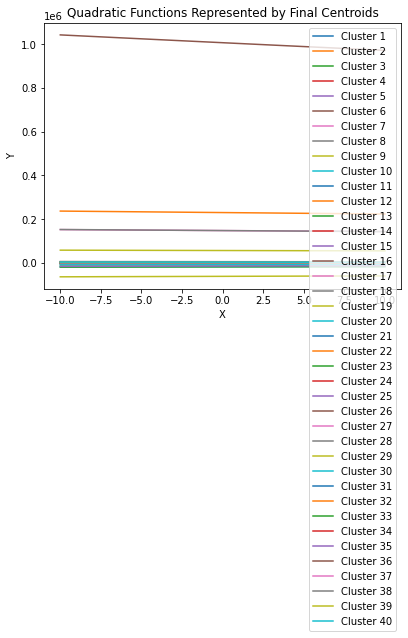

In [427]:
import matplotlib.pyplot as plt

def plot_quadratic_function(coefficients, label=None):
    x = np.linspace(-10, 10, 100)  # Adjust the range of x values as needed
    y = coefficients[0] * x ** 2 + coefficients[1] * x + coefficients[2]
    plt.plot(x, y, label=label)

# Plot the quadratic functions represented by the final centroids
for i, centroid in enumerate(centroids):
    plot_quadratic_function(centroid, label=f'Cluster {i+1}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quadratic Functions Represented by Final Centroids')
plt.legend()
plt.show()
